In [1]:
# Mounting my google drive to access data files
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# Importing Libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import sklearn 
pd.set_option('display.max_columns', None)

In [3]:
# Import Data
train = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/Kaggle/Digit recognizer/train.csv")
test = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/Kaggle/Digit recognizer/test.csv")

In [4]:
# Assigning features to variable X and labels to y
X = train.drop(labels=["label"], axis=1)
y = train.label

Text(0.5, 1.0, 'Label: 1')

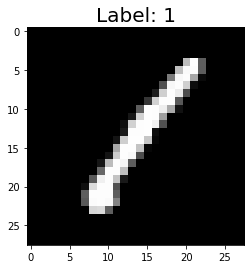

In [5]:
# Lets have a look at the first line of data
x = X[0:1].values.reshape(-1,28,28,1)
plt.imshow(np.reshape(x, (28,28)), cmap=plt.cm.gray)
plt.title('Label: %i' %y[0:1], fontsize = 20)

In [ ]:
# lets fit the data for Logistic regression model
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X,y)

In [7]:
# export predictions as CSV, funtion to predict on testset and save output
def save_csv(testset, filename):
  sub = model.predict(testset)
  sub = pd.DataFrame(sub, columns=['Label'])  #header of prediction will be Label
  sub.index = sub.index + 1                   #adding index which starts from 1
  sub.index.rename('ImageId', inplace=True)   #header of index column will be ImageId 
  sub.to_csv("/content/gdrive/My Drive/Colab Notebooks/Kaggle/Digit recognizer/"+filename+".csv")

In [11]:
save_csv(test, 'logreg')

The Kaggle score of this submission was 0.91617 with a Rank 2629

As the previous LBFGS failed to converge, lets try to converge it by scaling the features

Lets also try data augmentation and changing lbfgs parameters for convergence

1. Shifting
2. Rotating
3. Shearing
4. Cropping

In [12]:
# Scaling the features, fit and predict again
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
test_scaled = scaler.transform(test)
LR.fit(X_scaled,y)
save_csv(test_scaled, 'logreg_scaled')

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Score after scaling is 0.91889, slight improvement. 0.0027 to be exact

Now on to augmentation

In [13]:
# Augmenting with Keras, as Keras only takes in 4D array, reshaping my array so..
X = X.values.reshape(-1,28,28,1)

from keras_preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(  
        rotation_range=10,    
        zoom_range = 0.1,  
        width_shift_range=0.1,  
        height_shift_range=0.1,
        shear_range=0.1  
        )  

# instead of .fit; .flow can be used to generate and save data

augmented_data = []
augmented_labels = []
num_augmented = 0
batch = 1  # for 42000*1 = 84k entries
for X_batch, y_batch in datagen.flow(X, y, batch_size=batch, shuffle=False):  
    augmented_data.append(X_batch)
    augmented_labels.append(y_batch)
    num_augmented += 1
    if num_augmented == X.shape[0]:
        break
augmented_data = np.concatenate(augmented_data) 
augmented_labels = np.concatenate(augmented_labels)

In [15]:
augmented_data_reshaped = augmented_data.reshape(42000, 784)
augmented_dataframe = pd.DataFrame(augmented_data_reshaped)
header = list(test.columns.values)
augmented_dataframe.columns = header
augmented_dataframe.insert(0, "label", augmented_labels)
augmented_dataframe.to_csv("/content/gdrive/My Drive/Colab Notebooks/Kaggle/Digit recognizer/train_augmented.csv", index=False)

After a day of tinkering with `ImageDataGenerator` I was able to generate and save an augmented_dataframe, now I will be merging it with original train dataset which will give me 84000 rows  

In [16]:
X = augmented_dataframe.drop(labels=["label"], axis=1)
y = augmented_dataframe.label

Text(0.5, 1.0, 'Label: 1')

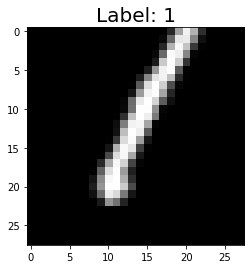

In [17]:
# Lets have a look at the first line of data
x = X[0:1].values.reshape(-1,28,28,1)
plt.imshow(np.reshape(x, (28,28)), cmap=plt.cm.gray)
plt.title('Label: %i' %y[0:1], fontsize = 20)

Compared to above image, this one has rotated a bit and lost its pixel values. As this result is random it looks different on each execution

In [18]:
# combining origial data with augmented data
data = [train, augmented_dataframe]
fulldata = pd.concat(data, ignore_index=True)

X = fulldata.drop(labels=["label"], axis=1)
y = fulldata.label

In [19]:
# lets fit the data for Logistic regression 
LR = LogisticRegression()
scaler.fit(X)
X_scaled = scaler.transform(X)
test_scaled = scaler.transform(test)
LR.fit(X_scaled,y)
save_csv(test_scaled, 'logreg_augmented')

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Model score deteriorated to 0.89435, enough with logistic regression hmph..

Lets try Random forest classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
#model.fit(X, y)
#save_csv(test, 'RForest')

Score was 0.9656 without scaling and augmenting, lets see what scaling and augmenting does

In [20]:
augmented_dataframe = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Kaggle/Digit recognizer/train_augmented.csv')
data = [train, augmented_dataframe]
fulldata = pd.concat(data, ignore_index=True)

X = fulldata.drop(labels=["label"], axis=1)
y = fulldata.label

In [21]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
test_scaled = scaler.transform(test)

In [ ]:
model.fit(X_scaled, y)
save_csv(test_scaled, 'RForest_scale_augment')

Score went from 0.9656 to 0.89485 after scaling and augmentation.
Clearly augmentation is not improving the score.
Next up is Convolutional neural network... someday, when I learn it...